In [1]:
import pandas as pd
import numpy as np

import lib.draw as draw
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error
import optuna
import pickle

from tqdm import tqdm

In [2]:
# Ajust to create denser maps
DENSITY_X, DENSITY_Y = 1, 1.77
ENABLE_OPTIMIZATION = False

# Loading data

In [3]:
df = pd.read_csv('data/formated_data.csv').drop('Unnamed: 0', axis = 1)
df = df[df.type.isin(['Pass', 'OffsidePass', 'CrossNotClaimed'])].dropna()
df = df[['x','y','r','a','success']]
df

x      y         r         a  success
0       0.501  0.519  0.138539  0.937521        1
1       0.372  0.573  0.223379  0.788126        1
2       0.333  0.766  0.191471  0.172119        1
3       0.253  0.678  0.358020  0.262014        1
4       0.365  0.114  0.533326  0.465716        0
...       ...    ...       ...       ...      ...
725716  0.755  0.917  0.225158  0.050314        1
725717  0.541  0.847  0.249359  0.233375        1
725718  0.526  0.597  0.442064  0.307016        1
725719  0.697  0.152  0.099005  0.998392        1
725720  0.627  0.128  0.722114  0.695376        1

[681989 rows x 5 columns]

# Calculating gradient

In [4]:
# Handler to create the dataframe and calculate xpmap
def calculate_xpmap(clf, fromX, fromY):
    xpmap = [[fromX/100, fromY/100, i/100, j/100] for i in range(0, 100, DENSITY_X) for j in np.arange(0, 100, DENSITY_Y)]
    xpmap = pd.DataFrame(xpmap, columns=['x','y', 'endX', 'endY'])
    xpmap['r'] = np.sqrt((xpmap.endX - xpmap.x) ** 2 + (xpmap.endY - xpmap.y) ** 2)
    xpmap['a'] = np.arctan2(xpmap.endY - xpmap.y, xpmap.endX - xpmap.x) / (2 * np.pi) + 0.5
    xpmap['xp'] = clf.predict_proba(xpmap[['x','y', 'r', 'a']])[:,1]

    return xpmap

## Check best fitted model using Bayesian Optimization

In [5]:
# Optimization function
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 5)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int('n_units_l{}'.format(i), 4, 128))

    activation = trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu'])
    lr = trial.suggest_float('learning_rate', 0.001, 0.05)
    lr_type = trial.suggest_categorical('learning_rate_type', ['constant', 'invscaling', 'adaptive'])
    max_iterations = trial.suggest_int('epochs', 20, 750)
    early_stop = trial.suggest_categorical('early_stop', [False, True])
    
    clf = MLPClassifier(hidden_layer_sizes=layers, activation=activation, learning_rate_init=lr, learning_rate=lr_type, max_iter=max_iterations, early_stopping=early_stop)
    clf.fit(sample_df[['x', 'y', 'r', 'a']], sample_df['success'])

    pred = clf.predict_proba(sample_df[['x', 'y', 'r', 'a']])[:,1]

    return mean_squared_error(pred, sample_df['success'])

In [6]:
# Run Bayesian Optimization Study
if ENABLE_OPTIMIZATION:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=250)
    print(study.best_params)

## Train model

In [7]:
clf = MLPClassifier(hidden_layer_sizes=[8, 86, 32, 128, 126], activation='tanh', learning_rate_init=0.0011742437070288558, learning_rate='invscaling', max_iter=352)
clf.fit(df[['x', 'y', 'r', 'a']], df['success'])

MLPClassifier(activation='tanh', hidden_layer_sizes=[8, 86, 32, 128, 126],
              learning_rate='invscaling',
              learning_rate_init=0.0011742437070288558, max_iter=352)

# Save model

In [9]:
pickle.dump(clf, open('env/matrix/pass_gradient.sav', 'wb'))

# Visualize the gradient

In [17]:
# Function to visualize the gradient
def plot_xpmap(xpmap, fromX, fromY):
    draw.pitch()
    
    xpmap[['x','y','endX','endY']] *= 100

    cmap = np.zeros((len(xpmap),4))
    cmap[:,0] = 0; cmap[:,1] = 0; cmap[:,2] = 0; cmap[:,3] = xpmap.xp

    plt.scatter(xpmap.endX, xpmap.endY, s = 15, c = cmap, marker = 's', linewidth=0, zorder = 10);
    plt.scatter(fromX, fromY, s = 15, c = 'C1', marker = 's', linewidth=0, zorder = 11)

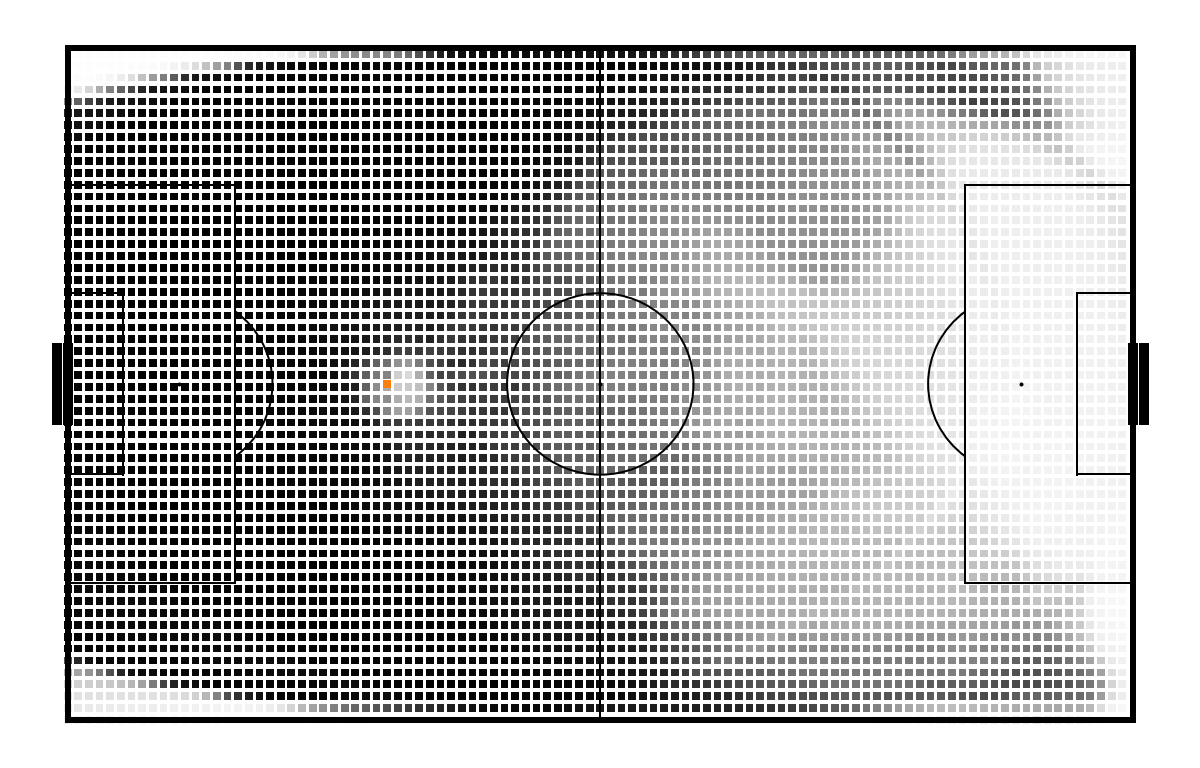

In [18]:
fromX, fromY = 30, 50
xpmap = calculate_xpmap(clf, fromX, fromY)
plot_xpmap(xpmap, fromX, fromY)

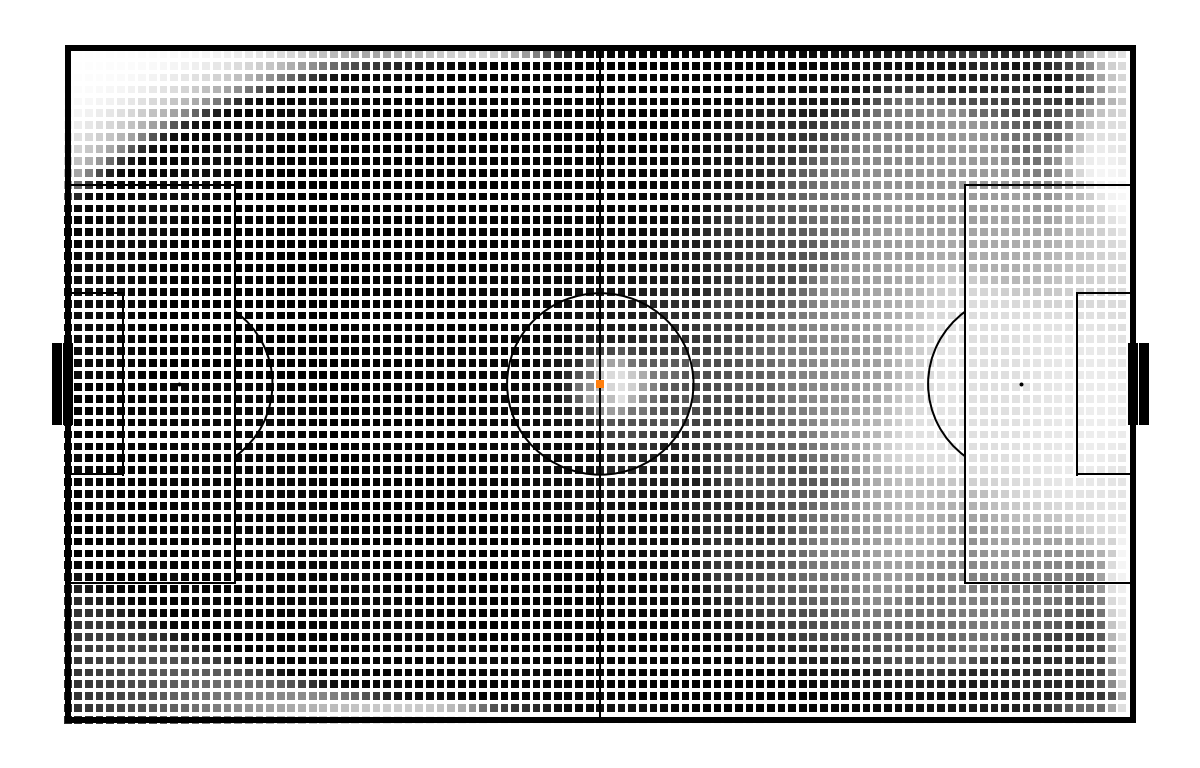

In [19]:
fromX, fromY = 50, 50
xpmap = calculate_xpmap(clf, fromX, fromY)
plot_xpmap(xpmap, fromX, fromY)

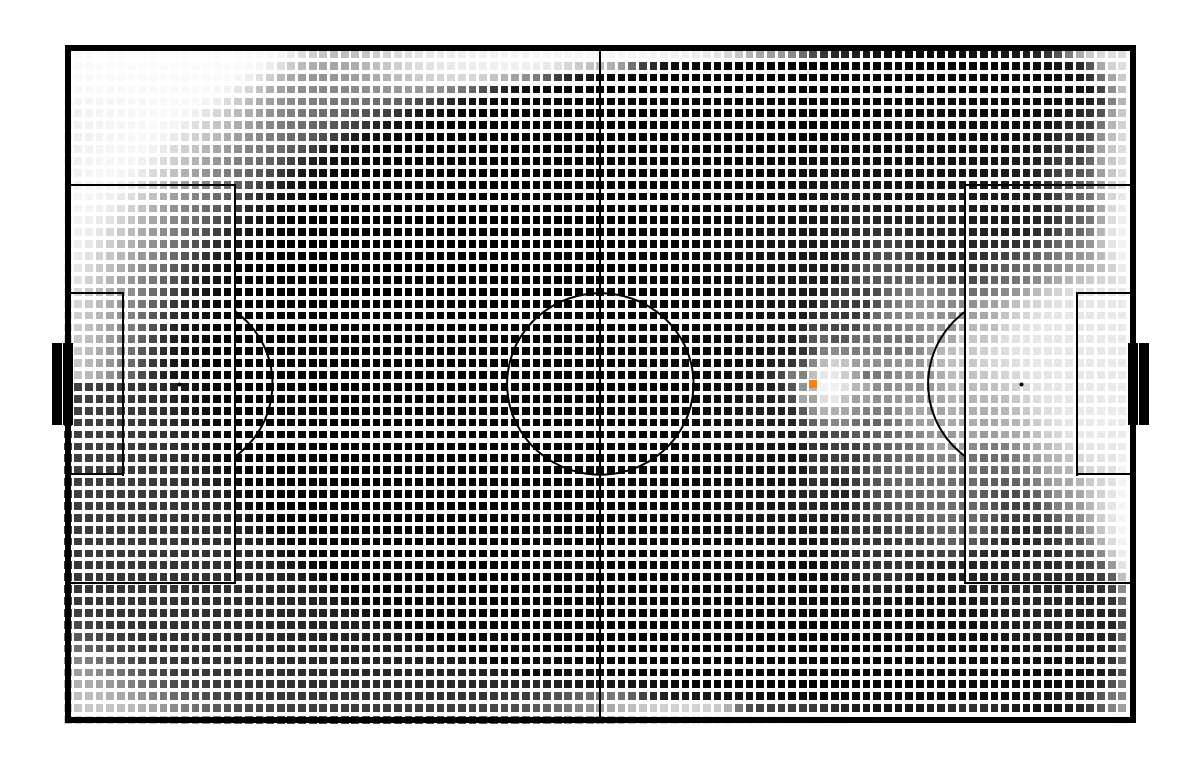

In [24]:
fromX, fromY = 70, 50
xpmap = calculate_xpmap(clf, fromX, fromY)
plot_xpmap(xpmap, fromX, fromY)

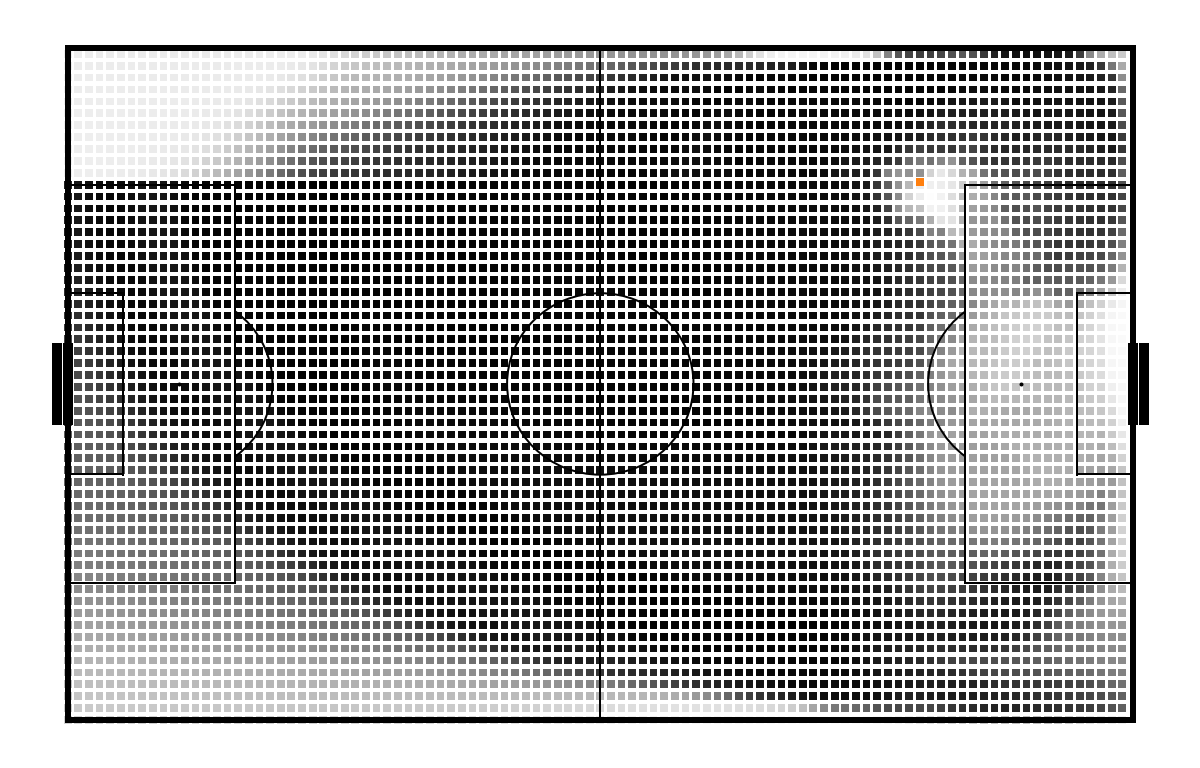

In [25]:
fromX, fromY = 80, 80
xpmap = calculate_xpmap(clf, fromX, fromY)
plot_xpmap(xpmap, fromX, fromY)

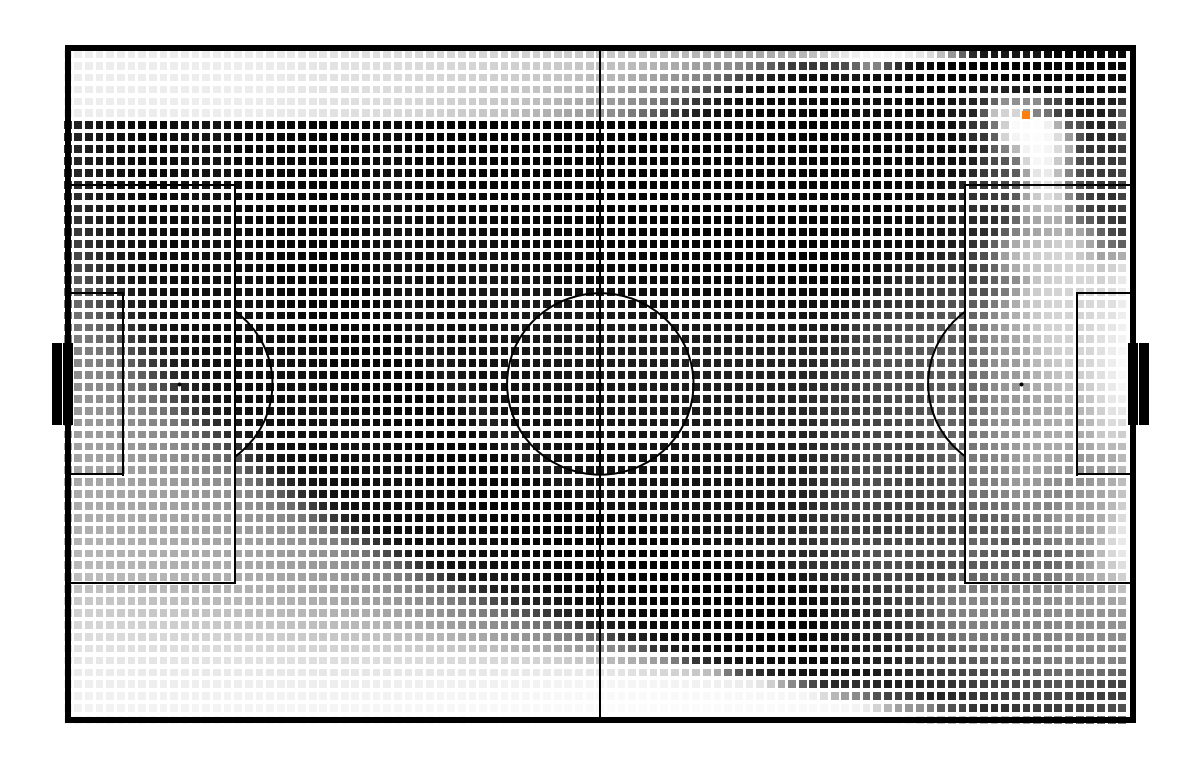

In [26]:
fromX, fromY = 90, 90
xpmap = calculate_xpmap(clf, fromX, fromY)
plot_xpmap(xpmap, fromX, fromY)

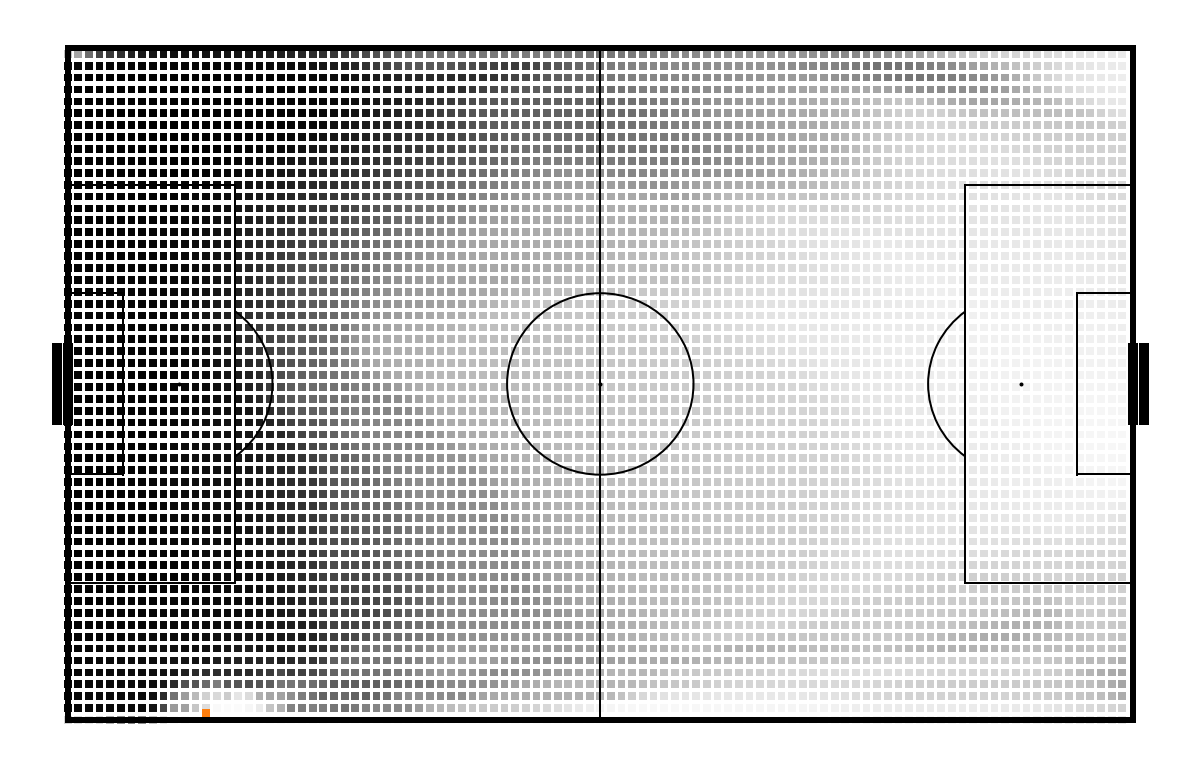

In [27]:
fromX, fromY = 13, 1
xpmap = calculate_xpmap(clf, fromX, fromY)
plot_xpmap(xpmap, fromX, fromY)